# Multiprocessing

A way to introduce paralellism and relase GIL to utilize the multicore microarchitecture, Multiprocessing is a useful python packages.

### Process
- A process is a self contained unit of execution of a program with its own memory address space and segment of available resources allocated to it (cores, registers, heap space etc). 
- Since two processes don't share the memory address space, the need a means to communicate.
- Processes are not lightweight for OS to manage, i.e. their creation and destruction. Therefore they are usually initialized and destroyed once in the lifetime of a programm.
- Think of parallelism with processes are 4 chefs making the same recipe of soup in 4 seperate kitchens. In term of the computer program, this means 4 instances of the same program.

### Thread
- A thread is a unit of execution within a process.
- A process can spwan many threads.
- When a process starts, it is assigned its registers, cores, heap and memory space for code. A thread of a process, when started, is assigned a subset of registers, core to run on. Each thread of the same process shares the same heap space and code's memory space.


- We discuss mulitprocessing package here because it is a prefered way to bypass GIL and maximize the computational resources available on a compute node.
- Multiprocessing is suitable for SMP (Symmertric Multiprocessing) style of programming.

# Getting started
## The Pool Class
- Controls a pool of workers. 
A pool of workers can be initiated by instantiating an object of Pool Class.

It is usually a good practice to pin one process a CPU.

Before anything, let's define work for each process. Given a list of numbers each worker will call a funtion to evaluate sqaure of a number from that list in parallel.

In [1]:
def square(x):
    return x * x

Now we define a pool of workers

In [2]:
import multiprocessing as mp

nprocs = mp.cpu_count()
print("%d worker available" %nprocs)

# let's create a pool of workers
pool = mp.Pool(processes=nprocs)

16 worker available


### The map method
This method takes the "work" as argument and maps it to the process in the pool. 
Let us define this "work" first and then we will map it to the available processes in the pool of workers.

Let's say we want squares of each number from 0 to 19 done in parallel by all the available workers in the Worker Pool instantiated above:

In [3]:
result = pool.map(square,range(20))
print("squares for sequence 0 to 19 :")
print(result)
pool.close()

squares for sequence 0 to 19 :
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]


### The starmap method
Notice that map() method of Pool class takes a single valued argument to the mapped function. For function that takes more than one argument, the Pool class also has starmap() function. 

Let's say we want to create a function that evaluates power of n of a number.

In [4]:
def power_n(x,n):
    return x ** n

In [5]:
pool = mp.Pool(processes=nprocs)
result = pool.starmap(power_n, [(x,2) for x in range(20)])
print("evaluation of sequence 0^2 to 19^2 :")
print(result)
pool.close()

evaluation of sequence 0^2 to 19^2 :
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]


Both map() and starmap() are synchronus methods of the Pool class. 
This implies that which every worker in the pool finishes first, will wait until all other finish, before going to the next instruction to execute.

### Computing $\pi$

As an example, we can try and parallelize a simple serial code which approximates the value of Pi by the following integral.
<h3><center>$\pi = \int_0^1 \frac{4}{1 + x^2}$</center></h3>

#### Serail Code

In [6]:
import time
nsteps = int(1e7)
dx= 1.0/nsteps
pi = 0.0
stime = time.time()
for i in range(nsteps):
    x = (i+0.5) * dx
    pi = pi + 4.0 /(1.0 + x*x)
stime = time.time() - stime
pi = pi * dx
print ("Pi = %2.10f calculated in %2.5f seconds" %(pi,stime))

Pi = 3.1415926536 calculated in 3.71492 seconds


- The above is a compute bound code as it spends most of its time in evaulating the x and pi values for nsteps times. 
- The approximation gets better as the nsteps increase.
Let's now attempt to see how we can make use of multiprocessing pool of workers. 

#### Paralell code
- For this, we will need to divide iterations of the for loop, "nsteps", into sub-tasks in round-robin fashion and map them to each worker in the Pool. 
- Once every worker has finished, we can accumulate partial Pi from each and add them up. 

Let's first define a function to evaluate partial Pi values which will be called by all workers for their respective iterations.

In [7]:
def partial_pi(rank,nprocs,nsteps,dx):
    partial_pi = 0.0
    for i in range(rank,nsteps,nprocs):
        x = (i+0.5) * dx
        partial_pi += 4.0 /(1.0 + x*x)
    partial_pi *= dx
    return partial_pi

We can divide the iterations in round robin fashion over the available processes in the pool and invoke "starmap" method on the Pool of workers to call paritial_pi with repective arguments.

In [8]:
args = [(rank,nprocs,nsteps,dx) for rank in range(nprocs)]
pool = mp.Pool(processes=nprocs)
ptime=time.time()
result = pool.starmap(partial_pi,args)
ptime=time.time() - ptime
pi = sum(result)
print ("Pi = %2.10f calculated in %2.5f seconds" %(pi,ptime))
pool.close()

Pi = 3.1415926536 calculated in 0.17091 seconds


### Scaling 

Though the computation is faster in the parallel version of the code using multiprocessing, it is worthwhile knowing the number of workers after which there is no performance gain (Speed Up). This is called a <b>Scaling test</b>.

In [9]:
workers=list()
compute_times=list()
speedup=list()
for i in range(5):
    workers.append(2 ** i)
    args = [(rank,workers[i],nsteps,dx) for rank in range(workers[i])]
    pool = mp.Pool(processes=workers[i])
    ptime=time.time()
    result = pool.starmap(partial_pi,args)
    ptime=time.time() - ptime
    compute_times.append(ptime)
    pi = sum(result)
    speedup.append(compute_times[0]/ptime)
    pool.close()

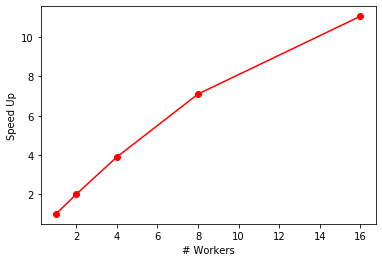

In [10]:
import matplotlib.pyplot as plt
plt.plot(workers,speedup,'ro-')
plt.xlabel('# Workers');
plt.ylabel('Speed Up');

## The Process Class
Another way to interact with multiple processes using the Multiprocessing package is to use the Process class.
It gives more fine grain control of individual processes rather then interacting with a pool of them.


Instantiating a process is calling the Process class with a target function and its arguements as a list. 
start() method starts the process by forking the parent process and join() will close or end the process.

To interact with the process's input and output stream, we can make use of <b>Queue class</b> to see the result. For this let's redefine the target function, square(). 

Here is how we can run multiple processes in parallel.

In [15]:
def square(x, q):
    q.put(x * x)

qout = mp.Queue()
processes = [mp.Process(target=square, args=(i, qout)) for i in range(20)]
for p in processes:
    p.start()

for p in processes:
    p.join()

result = [qout.get() for p in processes]
print(result)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]


It is important to note here that the execution of these processes is asynchronus. Thus the load imbalance between the processes should be taken into account and the processes need to be fed more work when they are done with theres'. 

Process class is a good tool for pipelining work using a Master process to control and workers to execute a task farm.